<a href="https://colab.research.google.com/github/tsaialice9/HW1_VAE_MNIST/blob/main/HW7_LSTM%E8%88%87_Transformer_%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-3746098528.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("2330.TW", start="2020-01-01", end="2024-12-31")# Test set 實際長度 91
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 2.0046 - val_loss: 2.2144
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.2767 - val_loss: 2.2644
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.1897 - val_loss: 2.3683
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.1921 - val_loss: 2.2895
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 1.1541 - val_loss: 2.2834
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 1.1137 - val_loss: 2.2149
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 1.1639 - val_loss: 2.2606
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 1.0822 - val_loss: 2.2147
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 1.0878 - val_loss: 2.2317
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 1.0558 - val_loss: 2.2142
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 1.0836 - val_loss: 2.2333
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 1.1

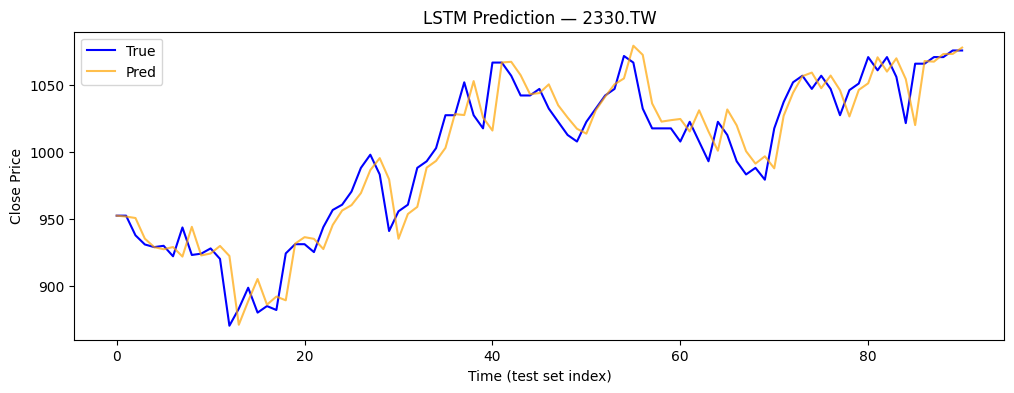

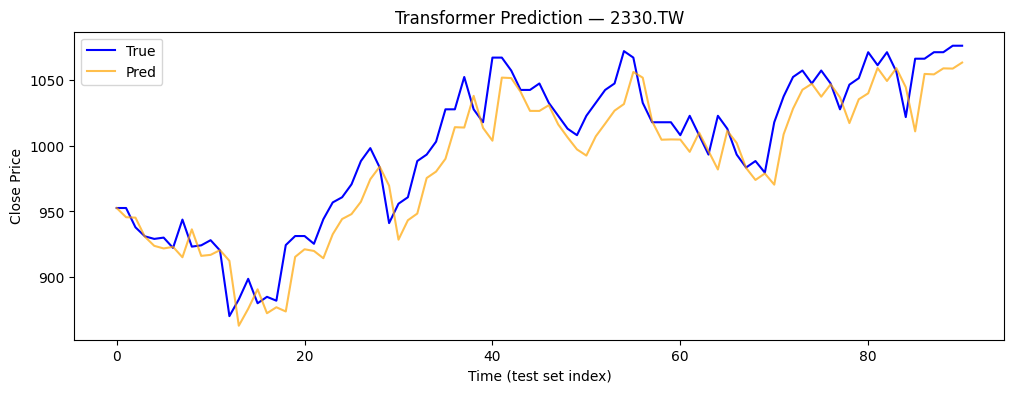

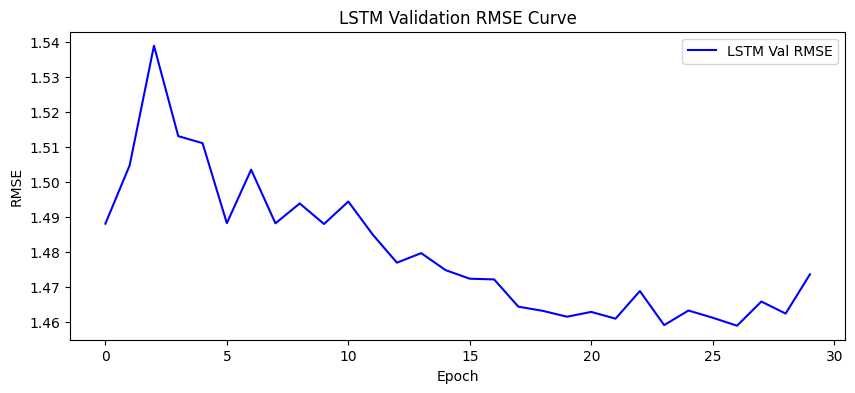

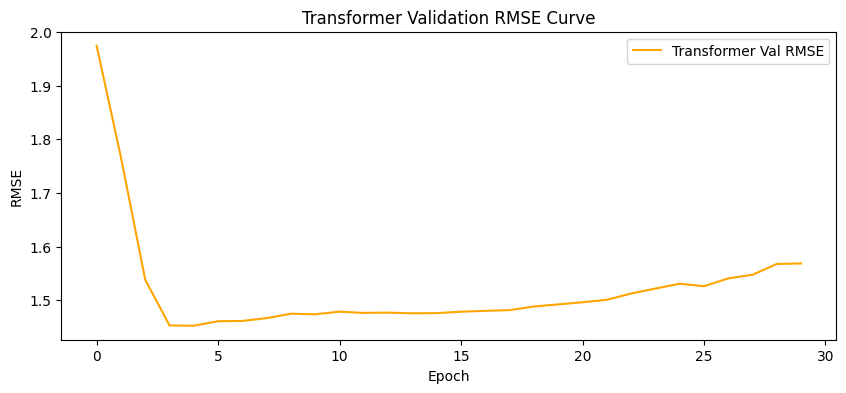

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


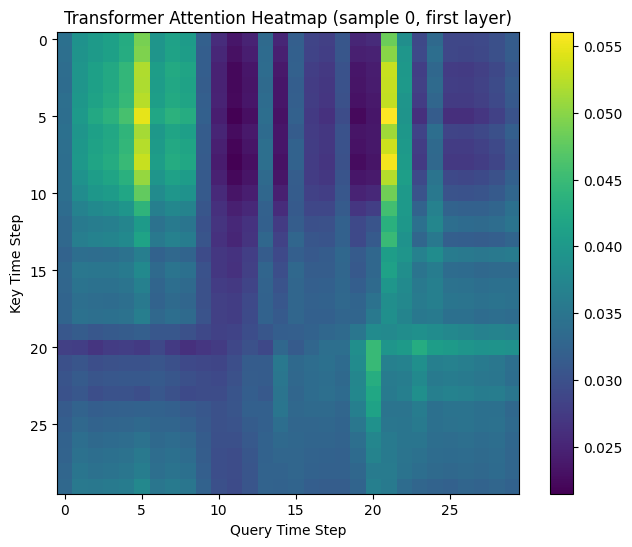

In [3]:

# LSTM + Transformer — 2330.TW 預測


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization, Input, MultiHeadAttention, GlobalAveragePooling1D
# Colab 無法安裝 tensorflow_addons，所以原本使用的 tfa.AdamW 已改成純 TensorFlow Adam
# import tensorflow_addons as tfa

# ===== 0️ 設定隨機種子 =====
np.random.seed(42)
tf.random.set_seed(42)

# ===== 1️ 下載資料 =====
df = yf.download("2330.TW", start="2020-01-01", end="2024-12-31")# Test set 實際長度 91
df = df[['Open','High','Low','Close','Volume']]

# ===== 2️ 計算 log return =====
df['logret'] = np.log(df['Close'] / df['Close'].shift(1))

# ===== 3️ 計算技術指標 =====
# 趨勢型
df['SMA_5'] = df['Close'].rolling(5).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()

# 震盪型
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 波動型
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_SIGNAL'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_HIST'] = df['MACD'] - df['MACD_SIGNAL']

# 量能型
df['VOL_CHG'] = df['Volume'].pct_change()

# ===== 4️ 刪掉缺失值 =====
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# ===== 5️ 特徵欄位 =====
features = ['logret','SMA_5','SMA_20','RSI_14','MACD','MACD_SIGNAL','MACD_HIST',
            'Open','High','Low','Volume']
data = df[features].values

# ===== 6️ 標準化 =====
lookback = 30
train_size = int(len(data)*0.8)
scaler = StandardScaler()
scaler.fit(data[:train_size])
data_scaled = scaler.transform(data)

# ===== 7️ 建立 X, y =====
X, y = [], []
for i in range(lookback, len(data_scaled)):
    X.append(data_scaled[i-lookback:i])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)

# ===== 8️ 拆分 Train/Val/Test =====
X_train, y_train = X[:955], y[:955]
X_val, y_val = X[955:955+119], y[955:955+119]
X_test, y_test = X[955+119:], y[955+119:]


# 9️ LSTM 模型

lstm_model = Sequential([
    LSTM(128, input_shape=(lookback, len(features))),
    Dropout(0.1),
    LayerNormalization(),
    Dense(1)
])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='mse')
history_lstm = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    verbose=1
)
y_pred_lstm_scaled = lstm_model.predict(X_test)


# 10️ Transformer 模型

d_model = 64
num_heads = 4
ffn_units = 256
dropout_rate = 0.1

def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2*(i//2))/np.float32(d_model))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = tf.cast(angle_rads, dtype=tf.float32)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)  # (1, seq_len, d_model)
    return pos_encoding

class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ffn_units, dropout_rate):
        super().__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = Sequential([Dense(ffn_units, activation='relu'), Dense(d_model)])
        self.norm1 = LayerNormalization()
        self.norm2 = LayerNormalization()
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def call(self, x, training=False, return_attn=False):
        attn_output, attn_scores = self.mha(x, x, return_attention_scores=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.norm2(out1 + ffn_output)
        if return_attn:
            return out2, attn_scores
        return out2

inputs = Input(shape=(lookback, len(features)))
x = Dense(d_model)(inputs)
x = x + positional_encoding(lookback, d_model)  # 修正 shape

encoder1 = TransformerEncoderLayer(d_model, num_heads, ffn_units, dropout_rate)
x, attn1 = encoder1(x, return_attn=True)
encoder2 = TransformerEncoderLayer(d_model, num_heads, ffn_units, dropout_rate)
x = encoder2(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(1)(x)
transformer_model = Model(inputs, outputs)

# ===== Transformer Optimizer + Warmup + CosineAnnealing =====
initial_lr = 3e-4
batch_size = 64
epochs = 30
total_steps = (len(X_train)//batch_size)*epochs
warmup_steps = int(total_steps*0.1)

def lr_schedule(step):
    step = int(step)
    if step < warmup_steps:
        lr = initial_lr * step / warmup_steps
    else:
        lr = 0.5 * initial_lr * (1 + np.cos(np.pi * (step - warmup_steps) / (total_steps - warmup_steps)))
    return float(lr)

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
transformer_model.compile(optimizer=optimizer, loss='mse')

history_tr = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[lr_callback]
)
y_pred_tr_scaled = transformer_model.predict(X_test)


# 11️ 計算指標（標準化 & 原始價格尺度）

def calc_metrics(y_true_scaled, y_pred_scaled, scaler, feature_idx=0, test_close=None):
    mse_s = mean_squared_error(y_true_scaled, y_pred_scaled)
    mae_s = mean_absolute_error(y_true_scaled, y_pred_scaled)
    rmse_s = np.sqrt(mse_s)

    y_true_orig = y_true_scaled * scaler.scale_[feature_idx] + scaler.mean_[feature_idx]
    y_pred_orig = y_pred_scaled.flatten() * scaler.scale_[feature_idx] + scaler.mean_[feature_idx]

    price_true = [test_close[0]]
    price_pred = [test_close[0]]
    for i in range(1, len(y_true_orig)):
        price_true.append(price_true[-1]*np.exp(y_true_orig[i]))
        price_pred.append(price_true[i-1]*np.exp(y_pred_orig[i]))
    price_true = np.array(price_true)
    price_pred = np.array(price_pred)

    mse_p = mean_squared_error(price_true, price_pred)
    mae_p = mean_absolute_error(price_true, price_pred)
    rmse_p = np.sqrt(mse_p)

    return (mse_s, mae_s, rmse_s, mse_p, mae_p, rmse_p, price_true, price_pred)

test_close = df['Close'].iloc[-len(y_test):].values
lstm_metrics = calc_metrics(y_test, y_pred_lstm_scaled, scaler, 0, test_close)
tr_metrics = calc_metrics(y_test, y_pred_tr_scaled, scaler, 0, test_close)


# 12️ Summary

print("=== SUMMARY ===")
print(f"TICKER:2330.TW, Period:2020-01-01~2024-12-31, TARGET_MODE=logret")
print(f"Lookback:{lookback},Features:{len(features)}")
print(f"Train/Val/Test size(rows):{len(X_train)}/{len(X_val)}/{len(X_test)}\n")
print(f"LSTM TEST (std):      MSE={lstm_metrics[0]:.6f} MAE={lstm_metrics[1]:.6f} RMSE={lstm_metrics[2]:.6f}")
print(f"LSTM TEST (original): MSE={lstm_metrics[3]:.4f} MAE={lstm_metrics[4]:.4f} RMSE={lstm_metrics[5]:.4f}\n")
print(f"TR TEST (std):        MSE={tr_metrics[0]:.6f} MAE={tr_metrics[1]:.6f} RMSE={tr_metrics[2]:.6f}")
print(f"TR TEST (original):   MSE={tr_metrics[3]:.4f} MAE={tr_metrics[4]:.4f} RMSE={tr_metrics[5]:.4f}")


# 13️ True vs Pred 圖表

plt.figure(figsize=(12,4))
plt.plot(lstm_metrics[6], label='True', color='blue')
plt.plot(lstm_metrics[7], label='Pred', color='orange', alpha=0.7)
plt.title("LSTM Prediction — 2330.TW")
plt.xlabel("Time (test set index)")
plt.ylabel("Close Price")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(tr_metrics[6], label='True', color='blue')
plt.plot(tr_metrics[7], label='Pred', color='orange', alpha=0.7)
plt.title("Transformer Prediction — 2330.TW")
plt.xlabel("Time (test set index)")
plt.ylabel("Close Price")
plt.legend()
plt.show()


# 14️ Validation RMSE 曲線

plt.figure(figsize=(10,4))
plt.plot(np.sqrt(history_lstm.history['val_loss']), label='LSTM Val RMSE', color='blue')
plt.title("LSTM Validation RMSE Curve")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(np.sqrt(history_tr.history['val_loss']), label='Transformer Val RMSE', color='orange')
plt.title("Transformer Validation RMSE Curve")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.legend()
plt.show()


# 15️ Transformer Attention Heatmap

attn_model = Model(inputs, attn1)
attn_sample = attn_model.predict(X_test[0:1])[0]
attn_avg = attn_sample.mean(axis=0)
plt.figure(figsize=(8,6))
plt.imshow(attn_avg, cmap='viridis')
plt.colorbar()
plt.title("Transformer Attention Heatmap (sample 0, first layer)")
plt.xlabel("Query Time Step")
plt.ylabel("Key Time Step")
plt.show()




=== LSTM 指標群組比較 ===
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Trend RMSE: 1.0245
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Momentum RMSE: 1.0799
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Volume RMSE: 1.0948
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Price RMSE: 1.0785


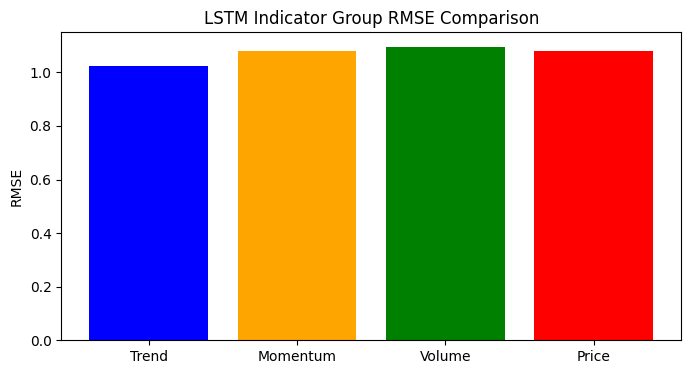


=== Transformer 指標群組比較 ===
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Trend RMSE: 1.0561
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Momentum RMSE: 1.0268
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Volume RMSE: 1.0238
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Price RMSE: 1.6513


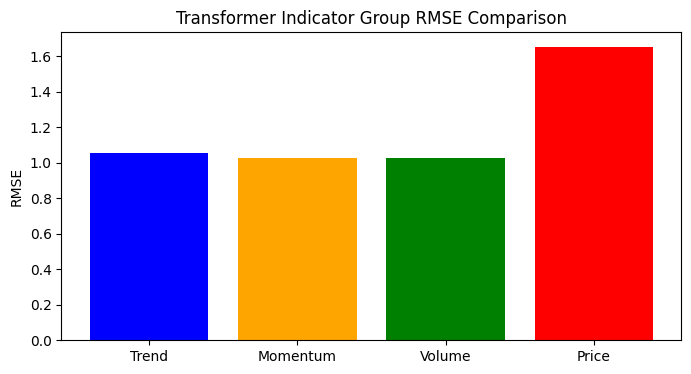

In [4]:

# 16️ 技術指標貢獻比較


indicator_groups = {
    'Trend': ['SMA_5','SMA_20'],
    'Momentum': ['RSI_14','MACD','MACD_SIGNAL','MACD_HIST'],
    'Volume': ['Volume','VOL_CHG'],
    'Price': ['Open','High','Low','Close']
}

for model_name, y_pred_scaled in zip(['LSTM','Transformer'], [y_pred_lstm_scaled, y_pred_tr_scaled]):
    print(f"\n=== {model_name} 指標群組比較 ===")
    rmse_list = []
    for group_name, cols in indicator_groups.items():
        # 取得該群組特徵索引
        idxs = [features.index(c) for c in cols if c in features]

        # 留一組特徵，其他歸零做影響測試
        X_test_masked = np.zeros_like(X_test)
        X_test_masked[:, :, idxs] = X_test[:, :, idxs]

        # 使用原模型預測（同樣模型數值，不重新訓練）
        if model_name=='LSTM':
            y_pred_group = lstm_model.predict(X_test_masked)
        else:
            y_pred_group = transformer_model.predict(X_test_masked)

        # 計算 RMSE（標準化空間）
        rmse_group = np.sqrt(mean_squared_error(y_test, y_pred_group))
        rmse_list.append(rmse_group)
        print(f"{group_name} RMSE: {rmse_group:.4f}")

    # 條形圖可視化
    plt.figure(figsize=(8,4))
    plt.bar(indicator_groups.keys(), rmse_list, color=['blue','orange','green','red'])
    plt.title(f"{model_name} Indicator Group RMSE Comparison")
    plt.ylabel("RMSE")
    plt.show()


